Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.45882356].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.64705884].
Clipping i

tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(2)


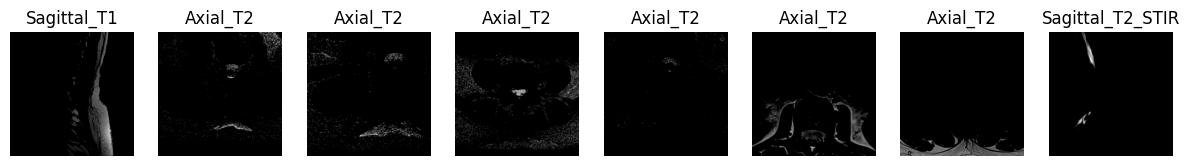

In [43]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

N_WORKERS = 0
BATCH_SIZE = 8
IMG_SIZE = [512, 512]
class_names = ["Axial_T2", "Sagittal_T1", "Sagittal_T2_STIR"]

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_map = {}

        # 检查目录是否存在
        if not os.path.exists(root_dir):
            raise FileNotFoundError(f"目录 {root_dir} 不存在")

        # 遍历目录，收集图像路径和标签
        for label_dir in os.listdir(root_dir):
            label_dir_path = os.path.join(root_dir, label_dir)
            if not os.path.isdir(label_dir_path):
                continue  # 如果不是目录，则跳过
            if label_dir not in self.class_map:
                self.class_map[label_dir] = len(self.class_map)
            for image_name in os.listdir(label_dir_path):
                try:
                    image_path = os.path.join(label_dir_path, image_name)
                    self.images.append(image_path)
                    self.labels.append(self.class_map[label_dir])
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        # 加载图像
        image = Image.open(image_path).convert('RGB')

        # 应用转换
        if self.transform:
            image = self.transform(image)

        return image, label


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE[0]),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ])
}

# 数据路径
data_dir = '../../data/rsna2024_small/mic-split'

# 创建数据集
train_dataset = CustomDataset(root_dir=os.path.join(data_dir, 'train_images'), transform=data_transforms['train'])
valid_dataset = CustomDataset(root_dir=os.path.join(data_dir, 'valid_images'), transform=data_transforms['valid'])
test_dataset = CustomDataset(root_dir=os.path.join(data_dir, 'test_images'), transform=data_transforms['test'])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

# 从训练数据加载器中获取一批数据
batch_images, batch_labels = next(iter(train_loader))

# 定义一个函数来显示图像
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # 反标准化
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 暂停一点时间，以便更新绘图

# 选择几个图像进行显示
fig, axes = plt.subplots(1, BATCH_SIZE, figsize=(15, 5))
for i, (img, label) in enumerate(zip(batch_images, batch_labels)):
    if i == BATCH_SIZE:
        break
    axes[i].imshow(img.permute(1, 2, 0))  # 调整通道顺序以适应matplotlib
    print(label)
    axes[i].set_title(class_names[label])
    axes[i].axis('off')
plt.show()

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # 替换最后的全连接层以匹配你的类别数
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'[INFO] Epoch {(epoch + 1):02d}/{num_epochs:02d}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 设置模型为训练模式
            else:
                model.eval()   # 设置模型为评估模式

            running_loss = 0.0
            running_corrects = 0

            # 使用tqdm包装数据加载器
            data_iter = tqdm(enumerate(dataloaders[phase]), total=len(dataloaders[phase]), desc=f'Epoch {epoch + 1} {phase}')

            # 迭代数据
            for i, (inputs, labels) in data_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只在训练阶段进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # 更新进度条
                data_iter.set_postfix(loss=loss.item())

            # 计算整个epoch的损失和准确率
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # 打印训练或验证阶段的结果
            if phase == 'train':
                print(f'>       train_loss: {epoch_loss:.4f} train_acc: {epoch_acc:.4f}')
            else:
                print(f'>       loss: {epoch_loss:.4f}       acc: {epoch_acc:.4f}')

dataloaders = {'train': train_loader, 'valid': valid_loader}
dataset_sizes = {'train': len(train_dataset), 'valid': len(valid_dataset)}
# class_names = sorted(train_dataset.labels)

train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

c:\Users\NilEra\.conda\envs\lspine-defender\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO] Epoch 00/09
>       train_loss: 0.7294 train_acc: 0.7132
>       loss: 0.4729       acc: 0.8553
[INFO] Epoch 01/09
>       train_loss: 0.3385 train_acc: 0.8824
>       loss: 0.2523       acc: 0.9474
[INFO] Epoch 02/09
>       train_loss: 0.2484 train_acc: 0.9007
>       loss: 0.3303       acc: 0.8289
[INFO] Epoch 03/09
>       train_loss: 0.2179 train_acc: 0.9007
>       loss: 0.2853       acc: 0.8553
[INFO] Epoch 04/09
>       train_loss: 0.2256 train_acc: 0.9228
>       loss: 0.2011       acc: 0.9342
[INFO] Epoch 05/09
>       train_loss: 0.1586 train_acc: 0.9412
>       loss: 0.1156       acc: 0.9737
[INFO] Epoch 06/09
>       train_loss: 0.1200 train_acc: 0.9559
>       loss: 0.1148       acc: 0.9737
[INFO] Epoch 07/09
>       train_loss: 0.1049 train_acc: 0.9559
>       loss: 0.1084       acc: 0.9605
[INFO] Epoch 08/09
>       train_loss: 0.1145 train_acc: 0.9559
>       loss: 0.1914       acc: 0.9079
[INFO] Epoch 09/09
>       train_loss: 0.0761 train_acc: 0.9743
>       l

In [30]:
# torch.save(model.state_dict(), './mic-results/resnet50_model.pth')

In [29]:
import torch
from torchvision import transforms
from PIL import Image

# 定义推理函数
def predict_image(image_path, model, class_names, device):
    # 加载模型权重
    model.load_state_dict(torch.load('./mic-results/resnet50_model.pth'))
    model = model.to(device)
    model.eval()  # 设置为评估模式

    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize(512),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ])

    # 加载图像
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # 增加批次维度

    # 推理
    with torch.no_grad():  # 不计算梯度
        inputs = image.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # 获取预测标签
    print(preds.item())
    predicted_label = class_names[preds.item()]

    return predicted_label

# 假设你已经有了 class_names 列表和模型定义
class_names = ["Axial_T2", "Sagittal_T1", "Sagittal_T2_STIR"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义你的模型结构
model = models.resnet50(pretrained=False)  # 以非预训练模式加载模型结构
model.fc = nn.Linear(model.fc.in_features, len(class_names))  # 替换最后的全连接层以匹配你的类别数

# 调用推理函数
image_path = 'E:/RSNA-Dataset/mic-split/test_images/Sagittal_T1/00001.png'
predicted_label = predict_image(image_path, model, class_names, device)
print(f'Predicted label: {predicted_label}')

C:\Users\NilEra\AppData\Local\Temp\ipykernel_31128\806285133.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./mic-results/resnet50_mod

1
Predicted label: Sagittal_T1


In [27]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np

# 定义推理函数
def predict_image(image_path, model, class_names, device):
    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ])

    # 加载图像
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # 增加批次维度

    # 推理
    with torch.no_grad():
        inputs = image.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # 获取预测标签
    predicted_label = class_names[preds.item()]

    return predicted_label

# 加载模型
def load_model(model_path, class_names, device):
    model = models.resnet50(pretrained=False)  # 以非预训练模式加载模型结构
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))  # 替换最后的全连接层以匹配你的类别数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()  # 设置为评估模式
    return model

# 预测每个类别的准确度
# 预测每个类别的准确度
def predict_accuracy(data_dir, model, class_names, device):
    correct_pred = {cls: 0 for cls in class_names}
    total_images = {cls: 0 for cls in class_names}

    # 获取所有类别目录
    all_cls_dirs = [os.path.join(data_dir, cls) for cls in class_names]

    # 创建一个tqdm进度条
    total_files = sum(len([f for f in os.listdir(d) if f.endswith(".png") or f.endswith(".jpg")]) for d in all_cls_dirs)
    pbar = tqdm(total=total_files, desc="Predicting")

    for cls in class_names:
        cls_dir = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_dir):
            if img_name.endswith(".png") or img_name.endswith(".jpg"):
                image_path = os.path.join(cls_dir, img_name)
                true_label = cls
                predicted_label = predict_image(image_path, model, class_names, device)
                total_images[cls] += 1
                if predicted_label == true_label:
                    correct_pred[cls] += 1
                # 更新进度条
                pbar.update(1)

    # 关闭进度条
    pbar.close()

    accuracy = {cls: correct_pred[cls] / total_images[cls] * 100 for cls in class_names}
    return accuracy


# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载模型
model_path = './mic-results/resnet50_model.pth'
model = load_model(model_path, class_names, device)

# 预测准确度
data_dir = 'E:/RSNA-Dataset/mic-split/test_images'  # 测试集路径
accuracy = predict_accuracy(data_dir, model, class_names, device)

# 打印每个类别的准确度
for cls, acc in accuracy.items():
    print(f'Accuracy for {cls}: {acc:.2f}%')

c:\Users\NilEra\.conda\envs\lspine-defender\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NilEra\.conda\envs\lspine-defender\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\NilEra\AppData\Local\Temp\ipykernel_31128\2231168112.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default

Accuracy for Axial_T2: 100.00%
Accuracy for Sagittal_T1: 100.00%
Accuracy for Sagittal_T2_STIR: 100.00%
